In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import pickle
import pydicom

In [3]:
DATA_DIR = Path('input/rsna-breast-cancer-detection/')

In [4]:
train = pd.read_csv(DATA_DIR/'train.csv')

# Load experiment

In [10]:
from datasets import *
from architectures import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from transforms import *
from configs import *
from kuma_utils.utils import sigmoid

In [8]:
cfg = Dataset02v0()
ds = PatientLevelDataset(
    df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
    flip_lr=False,
    preprocess=A.Compose([AutoFlip(), CropROI(threshold=0.1, buffer=160), A.Resize(768, 384)]),
    transforms=ToTensorV2(),
    # preprocess=cfg.preprocess['train'],
    # transforms=cfg.transforms['train']
)

In [7]:
cfg = Model05()
model = cfg.model(**cfg.model_params)

In [8]:
with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
    predictions = pickle.load(f)

/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/kumaconda22/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/kumaconda22/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/kumaconda22/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and wi

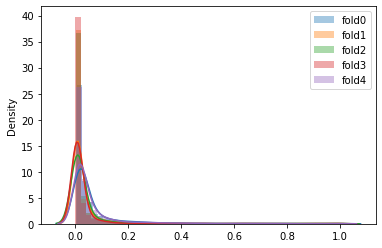

In [17]:
for fold_i, pred_fold in enumerate(predictions['outoffolds']):
    sns.distplot(sigmoid(pred_fold), bins=50, label=f'fold{fold_i}')
plt.legend()
plt.show()

In [19]:
for fold_i, pred_fold in enumerate(predictions['outoffolds']):
    print(fold_i, np.percentile(sigmoid(pred_fold), 98))

0 0.6503759590905779
1 0.3775231512068193
2 0.6052113604072159
3 0.44200783877257155
4 0.5537064517857491
